In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

## Introduction

Auditing is a critical process that protects the financial interests of a certain company. Auditing firms examine various documents and books of accounts to avoid fraudulent behaviour and errors in general. Auditors confirm that companies are lawfully orchestrating their business transactions through a series of interviews and record checks. They produce and share their findings with the company and expect an action plan from the company moving forward. To analyze a company’s records, classification methods using R can predict if a company is likely fraudulent or not. The dataset used is a multivariate dataset with audit data from 777 firms during 2015 to 2016. This data can help answer the question: Is inherent risk a good predictor in predicting fraudulent behaviour of a company?

## Preliminary exploratory data analysis

In [2]:
audit_risk <- read_csv("data/audit_risk.csv")
risk_dataset <- select(audit_risk, Score, Money_Value, Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk, Risk)
risk_dataset <- tibble::rowid_to_column(risk_dataset, "ID")
risk_dataset

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.4,3.38,8.574,0.4,0.5,1.7148,1
2,2.0,0.94,2.554,0.4,0.5,0.5108,0
3,2.0,0.00,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
774,2,0.00,1.456,0.4,0.5,0.2912,0
775,2,0.00,1.440,0.4,0.5,0.2880,0
776,2,0.32,1.464,0.4,0.5,0.2928,0


In [3]:
audit_risk_split <- initial_split(risk_dataset, prop = 0.75, strata = Risk)
audit_risk_train <- training(audit_risk_split)
audit_risk_test <- testing(audit_risk_split)

ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,2.0,0.00,1.416,0.4,0.5,0.2832,0
6,2.0,2.95,2.156,0.4,0.5,0.4312,0
10,2.4,1.93,4.372,0.4,0.5,0.8744,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
717,2.4,0.00,2.200,1.2,0.5,1.3200,1
725,3.2,0.43,6.580,0.4,0.5,1.3160,1
746,3.2,16.09,12.118,0.4,0.5,2.4236,1


[1] 581

Risk,n,precentage
<dbl>,<int>,<dbl>
0,353,60.75731
1,228,39.24269


score_min,score_max
<dbl>,<dbl>
2,5.2


mean(Score)
<dbl>
2.700516


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



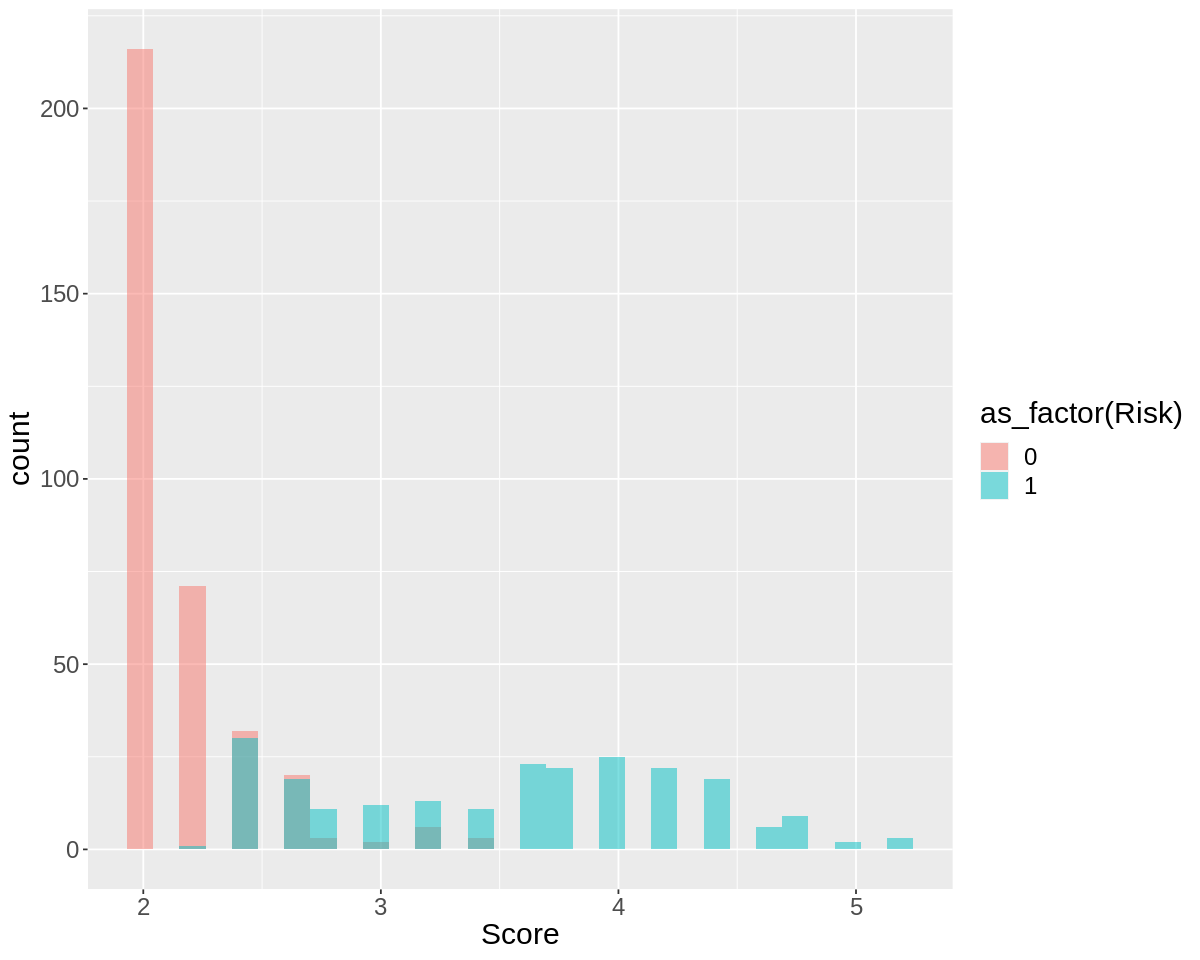

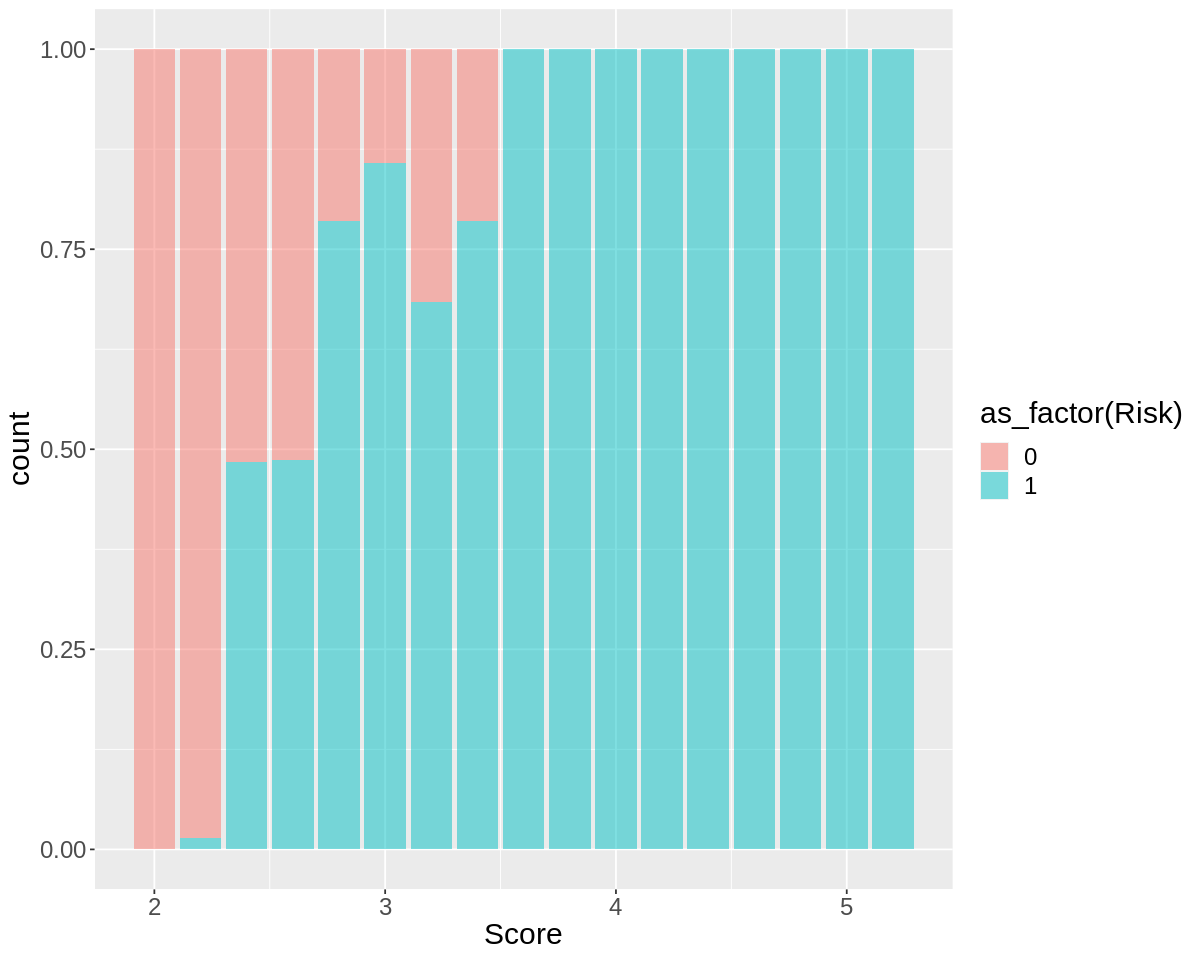

In [128]:
audit_risk_train
# Number of observations
num_obs <- nrow(audit_risk_train)
num_obs

#Total number and percentage of different type of Risk
risk_sum <- audit_risk_train |>
group_by(Risk)|>
summarize(n = n(), precentage= n() / num_obs * 100) |>
arrange(desc(n))
risk_sum

#Max and min value of the predictor variable (Score)
Audit_Risk_score <- summarize(audit_risk_train, score_min = min(Score, na.rm = TRUE),
                 score_max = max(Score, na.rm = TRUE))
Audit_Risk_score

#Mean value of the predictor variable (Score)
audit_risk_train |>
summarize(mean(Score))

#Histogram (Score)
options(repr.plot.width = 10, repr.plot.height = 8)
audit_risk_hist <- ggplot(audit_risk_train, aes(x = Score, fill = as_factor(Risk))) +
                          geom_histogram(alpha = 0.5, position = "identity") + theme(text = element_text(size = 18)) 
audit_risk_hist


#Bar plot (Score)
audit_risk_barplot <- ggplot(audit_risk_train, aes(x = Score, fill = as_factor(Risk))) +
                          geom_bar(alpha = 0.5, position = "fill") + theme(text = element_text(size = 18)) 
audit_risk_barplot

## Methods

Risk is a class assigned to audit cases, which in the dataset represents whether a company is fraudulent using dummy/binary variable. (0 means not fraudulent; 1 means fraudulent). The goal of the project is to assist the auditors by developing a classification model to determine/predict whether a company is fraudulent or not based on the previous risk factors. To conclude, for this project, Score will be employed as the predictor to determine the fraudulent company, a categorical label.


- We will first upload the dataset onto R and read the dataset using read_csv function.

- Then, we will start building our classification model by creating the training and testing datasets and splitting the data using 75% of the audit data as our training set and setting Risk as the strata argument.

- Next, we’ll use cross-validation with 5 folds on our training data to choose k: 
Create audit_spec
input “kknn” for the model engine and “classification” for the mode.

- Create an audit_recipe to preprocess the data 
recipe(Risk~Score, data = audit_training)
scale and centre the predictor

- Use vfold_cv function to set v = 5 and strata = audit_risk

- Set an an audit_workflow using audit_recipe and audit_spec

- Use the tune_grid function to estimate the classifier accuracy for a range of K values

- Compute the accuracy
audit_test_predictions |>
  metrics(truth = Risk, estimate = .pred_class) |>
  filter(.metric == "accuracy")
  
- Tuning the classifier
generate a tibble with a column called neighbors that contains a sequence value of 1 to #
Tune audit_workflow and resamples the cross validation datasets
Record the information in a metrics

- Create a line plot (with points on it to represent each K) to determine the best K

- Fit the audit_training into the workflow

- Use the predict function and bind_cols function to predict the result in the test set
audit_test_predictions <- predict(knn_fit, audit_test) |>
  bind_cols(audit_test)





## Expected outcomes and significance

It is expected that as money value increases, the risk of fraudulence increases proportionally. This finding can impact bigger corporations, as the more money a company has, the more likely fraudulent behaviour has occurred within the company. However, there are exceptions to this finding - there is a chance that companies with lower money value can still commit fraud. Moreover, it is expected that a company with a score over 2 would be considered fraudulent since score is used to predict risk. This would prompt more audits to occur in these bigger companies to further investigate the likelihood of fraud. To combat the high risk of fraud, how can we monitor these corporations so that fraud is reduced as money value increases? What can governing bodies do to ensure discrepancies in accounts do not go unnoticed? 
